#Global Climate Trends

##Analysis


In [1]:
# Dependencies and Setup
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

In [2]:
# Folder paths
input_folder = os.path.join('input')
output_folder = os.path.join('output')

In [3]:
def process_file(file_name, column_name):
    # Create array to store data for merging
    df_array = []

    # Read the csv file
    input_df = pd.read_csv(os.path.join(input_folder, file_name))

    # Loop over the columns of the dataframe skipping the first column
    for column in input_df.columns[1:]:
        # Create a new dataframe with the country and the year
        temp_df = input_df[['Country', column]].copy()

        # Adding a new column to the dataframe and positionong
        temp_df.insert(0, 'Year', column)

        # Rename for column
        temp_df.rename(columns={column: column_name}, inplace=True)

        # Adding the new dataframe to the array
        df_array.append(temp_df)

    return pd.concat(df_array, ignore_index=True)

In [4]:
def merge_dfs(dfs, column_list):
    # Store the first dataframe as initial value
    merged_df = dfs[0]

    # Loop over the dataframes starting from the second place in the array - always the 2nd, regardless of the df
    for df in dfs[1:]:
        # Merge the dataframes
        merged_df = pd.merge(merged_df, df, on=column_list, how='outer')

    # Return the merged dataframe
    return merged_df

In [5]:
dfs = [
    process_file('primary_energy_consumption.csv', 'Primary Energy Consumption'),
    process_file('energy_consumption_per_capita.csv', 'Energy Consumption per Capita'),
    process_file('co2_emissions.csv', 'CO2 Emissions'),
]

merged_dfs = merge_dfs(dfs, ['Country', 'Year'])
merged_dfs

,Year,Country,Primary Energy Consumption,Energy Consumption per Capita,CO2 Emissions
0,1985,Canada,10.29,398.0,403.5
1,1985,Mexico,4.08,54.5,233.9
2,1985,US,72.66,309.0,4576.0
3,1985,Argentina,1.73,57.2,94.6
4,1985,Brazil,4.94,36.1,185.0
...,...,...,...,...,...
3453,2022,Sri Lanka,0.34,15.7,19.9
3454,2022,Taiwan,4.78,200.2,272.4
3455,2022,Thailand,5.06,70.6,275.3
3456,2022,Vietnam,4.59,46.7,270.0


In [6]:
# Read the energy data per source
energy_source_df = pd.read_csv(os.path.join(input_folder, 'energy_consumption_by_source.csv'))
energy_source_df

,Country,Product,Flow,1990,1991,1992,1993,1994,1995,1996,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022 Provisional
0,Australia,Nuclear,Total_final_consumption,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,..
1,Austria,Nuclear,Total_final_consumption,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,..
2,Belgium,Nuclear,Total_final_consumption,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,..
3,Canada,Nuclear,Total_final_consumption,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,..
4,Chile,Nuclear,Total_final_consumption,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Non-OECD Europe and Eurasia,Natural gas,Total_final_consumption,10818,10599,9828,9652,8829,8569,8528,...,8613,8819,8661,9142,9829,10638,10548,10444,11092,..
301,Middle East,Natural gas,Total_final_consumption,1308,1476,1603,1701,2017,2219,2262,...,7170,7465,7804,7961,7588,7322,8580,8979,9093,..
302,IEA Total,Natural gas,Total_final_consumption,24649,25312,25486,26412,26624,27708,29539,...,31367,30678,30301,30804,31514,32952,32898,31262,32879,..
303,IEA and Accession/Association countries,Natural gas,Total_final_consumption,27664,28561,28831,29615,29727,30897,33211,...,40952,40364,39929,40747,42303,45065,45852,44612,47642,..


In [7]:
# Create an array to store the dataframes
df_energy_source_array = []

# Loop over unique values in the column "Product"
for product in energy_source_df['Product'].unique():

    # Create an array to store the temporary dataframes
    df_array = []

    # Loop over the columns of the dataframe skipping the first 3 columns
    for column in energy_source_df.columns[3:]:
        
        # Filter the dataframe where column "Product" is equal to the product
        filtered_df = energy_source_df[energy_source_df['Product'] == product]

        # Create a new dataframe with the country and the year
        temp_df = filtered_df[['Country', column]].copy()

        # Add a new "Year" column to the dataframe
        temp_df.insert(0, 'Year', column)
            
        # Rename the value column
        temp_df.rename(columns={column: f'Energy Source {product}'}, inplace=True)

        # Adding the new dataframe to the array
        df_array.append(temp_df)

    # Concatenate the dataframes in the array
    df_merged = pd.concat(df_array, ignore_index=True)

    # Append the dataframe to the final array
    df_energy_source_array.append(df_merged)

# Merge the dataframes
merged_energy_source_df = merge_dfs(df_energy_source_array, ['Country', 'Year'])
merged_energy_source_df


,Year,Country,Energy Source Nuclear,"Energy Source Coal, peat and oil shale",Energy Source Oil products,Energy Source Electricity,Energy Source Natural gas
0,1990,Australia,0,191,1214,465,362
1,1990,Austria,0,59,370,154,127
2,1990,Belgium,0,148,682,209,286
3,1990,Canada,0,134,2740,1505,1813
4,1990,Chile,0,26,230,56,38
...,...,...,...,...,...,...,...
2008,2022 Provisional,Non-OECD Europe and Eurasia,..,..,..,..,..
2009,2022 Provisional,Middle East,..,..,..,..,..
2010,2022 Provisional,IEA Total,..,..,..,..,..
2011,2022 Provisional,IEA and Accession/Association countries,..,..,..,..,..


In [8]:
# Find overlapping values in column between the two dataframes
def find_overlap(dfs, column):
    # Create a set to store the unique values of the first dataframe
    unique_values = set(dfs[0][column].unique())

    # Loop over the dataframes starting from the second place in the array
    for df in dfs[1:]:
        # Update the set with the unique values of the current dataframe
        unique_values = unique_values.intersection(df[column].unique())

    # Return the set
    return unique_values


In [9]:
# Filter the dataframe to keep only values in the list per column
def filter_df(df, column, values):
    # Return the filtered dataframe
    return df[df[column].isin(values)]

In [10]:
# Find year and country intersection between the two dataframes
years = find_overlap([merged_dfs, merged_energy_source_df], 'Year')
countries = find_overlap([merged_dfs, merged_energy_source_df], 'Country')

# Filter the dataframes
filtered_df = filter_df(filter_df(merged_dfs, 'Year', years), 'Country', countries)
filtered_energy_source_df = filter_df(filter_df(merged_energy_source_df, 'Year', years), 'Country', countries)

# Merge the dataframes based on year and country
final_df = pd.merge(filtered_df, filtered_energy_source_df, on=['Country', 'Year'], how='outer')

# Write the final dataframe to a csv file
final_df.to_csv(os.path.join(output_folder, 'final_data.csv'), index=False)

final_df


,Year,Country,Primary Energy Consumption,Energy Consumption per Capita,CO2 Emissions,Energy Source Nuclear,"Energy Source Coal, peat and oil shale",Energy Source Oil products,Energy Source Electricity,Energy Source Natural gas
0,1990,Canada,10.83,391.6,444.8,0,134,2740,1505,1813
1,1990,Mexico,4.75,58.1,280.8,0,46,2141,361,582
2,1990,US,81.38,328.0,4970.5,0,2329,28608,9481,12689
3,1990,Argentina,1.85,56.6,100.3,0,18,620,146,421
4,1990,Brazil,5.64,37.4,206.4,0,154,2238,759,106
...,...,...,...,...,...,...,...,...,...,...
1499,2021,Indonesia,7.76,28.3,519.6,0,881,2647,1030,689
1500,2021,Japan,17.94,144.0,1066.6,0,843,5510,3355,1182
1501,2021,New Zealand,0.85,165.3,32.5,0,22,270,140,94
1502,2021,Singapore,3.28,551.9,213.3,0,8,519,193,65


## What are the projected carbon footprints of countries in the next 10-20 years, considering population growth and the distribution of energy sources?

In [12]:
# Get count of countries
country_counts = final_df['Country'].value_counts()

# Print each unique country
for country, count in country_counts.items():
    print(country)

# List the total number of unique countries
total_countries = len(country_counts)
print(f'Total number of unique countries: {total_countries}')

Canada
Israel
Portugal
Slovakia
Slovenia
Spain
Sweden
Switzerland
Turkey
Ukraine
United Kingdom
Egypt
Norway
Morocco
South Africa
Australia
China
India
Indonesia
Japan
New Zealand
Singapore
Poland
Netherlands
Mexico
Estonia
US
Argentina
Brazil
Chile
Colombia
Austria
Belgium
Czech Republic
Denmark
Finland
Luxembourg
France
Germany
Greece
Hungary
Iceland
Ireland
Italy
Latvia
Lithuania
Thailand
Total number of unique countries: 47


In [93]:
# Calculate total energy consumption per capita over time
average_energy_consumption_per_capita = final_df.groupby('Year')['Energy Consumption per Capita'].mean()

# Print 
print(f'Year | Average Energy Consumption per Capita {total_energy_consumption}')

Year | Average Energy Consumption per Capita Year
1990    154.253191
1991    152.827660
1992    148.557447
1993    148.068085
1994    149.376596
1995    150.855319
1996    153.608511
1997    154.495745
1998    155.755319
1999    156.091489
2000    158.474468
2001    160.178723
2002    160.342553
2003    160.572340
2004    164.625532
2005    165.374468
2006    166.038298
2007    168.210638
2008    169.785106
2009    161.727660
2010    165.887234
2011    163.110638
2012    162.453191
2013    160.910638
2014    157.461702
2015    157.510638
2016    158.644681
2017    160.738298
2018    160.440426
2019    157.038298
2020    146.702128
2021    150.929787
Name: Energy Consumption per Capita, dtype: float64


In [96]:
# Calculate percentage change of energy use per capita over the years
average_energy_consumption_per_capita_shifted = average_energy_consumption_per_capita.shift(1)
percentage_change = ((average_energy_consumption_per_capita - average_energy_consumption_per_capita_shifted) / average_energy_consumption_per_capita_shifted) * 100

# Combine average energy consumption per capita and percentage change into a new DataFrame with percentages
average_energy_df = pd.DataFrame({
    'Average Annual Percentage Change of Energy Use per Capita': percentage_change.map("{:.2f}%".format)
})

# Print the average energy consumption per capita percentage change over time
print(average_energy_df)

     Average Annual Percentage Change of Energy Use per Capita
Year                                                          
1990                                               nan%       
1991                                             -0.92%       
1992                                             -2.79%       
1993                                             -0.33%       
1994                                              0.88%       
1995                                              0.99%       
1996                                              1.83%       
1997                                              0.58%       
1998                                              0.82%       
1999                                              0.22%       
2000                                              1.53%       
2001                                              1.08%       
2002                                              0.10%       
2003                                              0.14%

In [86]:
# Analyze and compare CO2 emissions and energy consumption

# Convert to numerical values to avoid error
final_df['CO2 Emissions'] = pd.to_numeric(final_df['CO2 Emissions'], errors='coerce')
final_df['Primary Energy Consumption'] = pd.to_numeric(final_df['Primary Energy Consumption'], errors='coerce')

# Define columns for comparison
co2_emissions = final_df['CO2 Emissions']
energy_consumption = final_df['Primary Energy Consumption']

# Solve for correlation of CO2 emission and average energy consumption, print out result
consumption_emissions_corr = co2_emissions.corr(energy_consumption)
print(f"Correlation between CO2 emissions and energy consumption: {consumption_emissions_corr}")

Correlation between CO2 emissions and energy consumption: 0.9881976603478702


CO2 emissions and energy consumption have a very strong positive correlation. This indicates that there is a strong linear relationship between CO2 emissions and energy consumption. In practical terms, this means that as energy consumption increases, CO2 emissions tend to increase as well.

Correlation between CO2 emissions and energy consumption: 0.9881976603478702


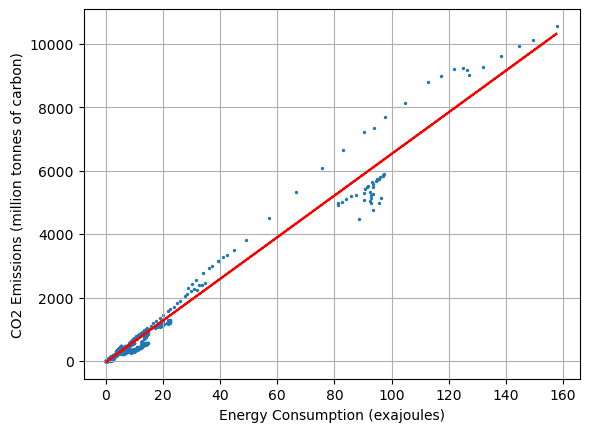

In [87]:
# Create graph to visualize correlation between energy consumption and CO2 emission
consumption_emissions_corr = co2_emissions.corr(energy_consumption)

slope, intercept, rvalue, pvalue, stderr = linregress(energy_consumption, co2_emissions)

plt.scatter(energy_consumption, co2_emissions, s=2)
plt.plot(energy_consumption, slope * energy_consumption + intercept, color = 'red')

plt.xlabel('Energy Consumption (exajoules)')
plt.ylabel('CO2 Emissions (million tonnes of carbon)')
plt.grid(True)

print(f"Correlation between CO2 emissions and energy consumption: {consumption_emissions_corr}")
plt.show()

In [88]:
# Analyze and compare CO2 emissions and energy consumption per capita

# Convert to numerical value
final_df['CO2 Emissions'] = pd.to_numeric(final_df['CO2 Emissions'], errors='coerce')
final_df['Energy Consumption per Capita'] = pd.to_numeric(final_df['Energy Consumption per Capita'], errors='coerce')

# Define columns for comparison
co2_emissions = final_df['CO2 Emissions']
energy_consumption_per_capita = final_df['Energy Consumption per Capita']

# Calculate correlation
capita_emissions_corr = co2_emissions.corr(energy_consumption_per_capita)
print(f"Correlation between CO2 emissions and energy consumption per capita: {capita_emissions_corr}")

Correlation between CO2 emissions and energy consumption per capita: 0.011499329184246069


CO2 emissions and energy consumption per capita have an extremely weak positive correlation.

Correlation between CO2 emissions and energy consumption per capita: 0.011499329184246069


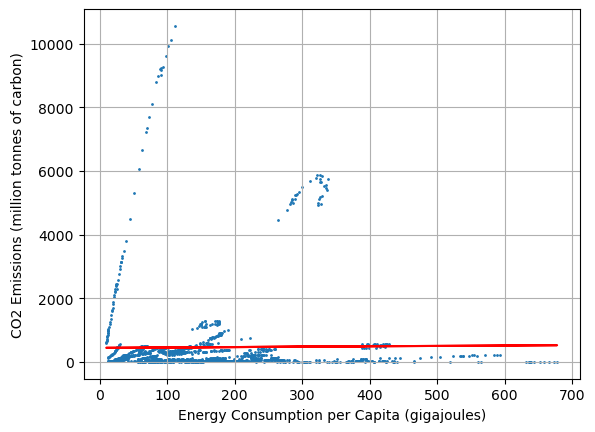

In [89]:
# Create graph to visualize correlation between CO2 emissions and energy consumption per capita
capita_emissions_corr = co2_emissions.corr(energy_consumption_per_capita)

slope, intercept, rvalue, pvalue, stderr = linregress(energy_consumption_per_capita, co2_emissions)

plt.scatter(energy_consumption_per_capita, co2_emissions, s=1)
plt.plot(energy_consumption_per_capita, slope * energy_consumption_per_capita + intercept, color = 'red')

plt.xlabel('Energy Consumption per Capita (gigajoules)')
plt.ylabel('CO2 Emissions (million tonnes of carbon)')
plt.grid(True)

print(f"Correlation between CO2 emissions and energy consumption per capita: {capita_emissions_corr}")
plt.show()

In [90]:
# Group by Year and calculate the average energy consumption per each energy source
average_energy_per_source_by_year = final_df.groupby('Year').agg({
    'Energy Source Nuclear': 'mean',
    'Energy Source Coal, peat and oil shale': 'mean',
    'Energy Source Oil products': 'mean',
    'Energy Source Electricity': 'mean',
    'Energy Source Natural gas': 'mean'
})

# Find the most common energy source for each year based on the largest unit
most_common_energy_source_per_year = average_energy_per_source_by_year.idxmax(axis=1)

# Print or visualize the average energy consumption per each energy source by year and the most common energy source for each year
print("Average Energy Consumption per Each Energy Source by Year:")
print(average_energy_per_source_by_year)
print("\nMost Common Energy Source for Each Year:")
print(most_common_energy_source_per_year)

Average Energy Consumption per Each Energy Source by Year:
     Energy Source Nuclear Energy Source Coal, peat and oil shale  \
Year                                                                
1990                   0.0                             550.148936   
1991                   0.0                              540.93617   
1992                   0.0                             506.382979   
1993                   0.0                             504.255319   
1994                   0.0                             499.255319   
1995                   0.0                                  519.0   
1996                   0.0                             479.553191   
1997                   0.0                             484.148936   
1998                   0.0                             468.553191   
1999                   0.0                             424.659574   
2000                   0.0                             424.042553   
2001                   0.0                  

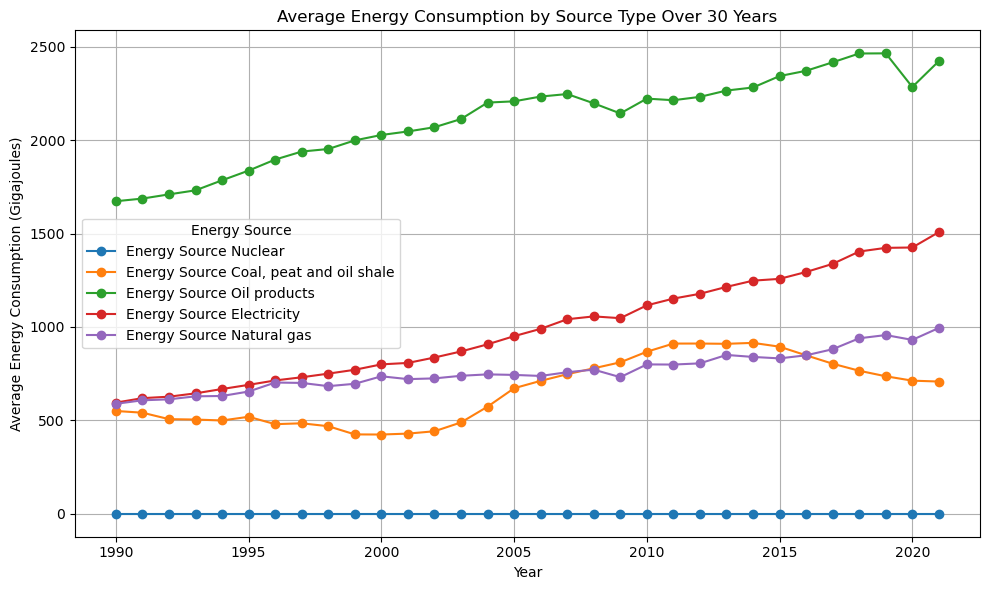

In [91]:
# Plotting the data
average_energy_per_source_by_year.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average Energy Consumption by Source Type Over 30 Years')
plt.xlabel('Year')
plt.ylabel('Average Energy Consumption (Gigajoules)')
plt.grid(True)
plt.legend(title='Energy Source')
plt.tight_layout()
plt.show()

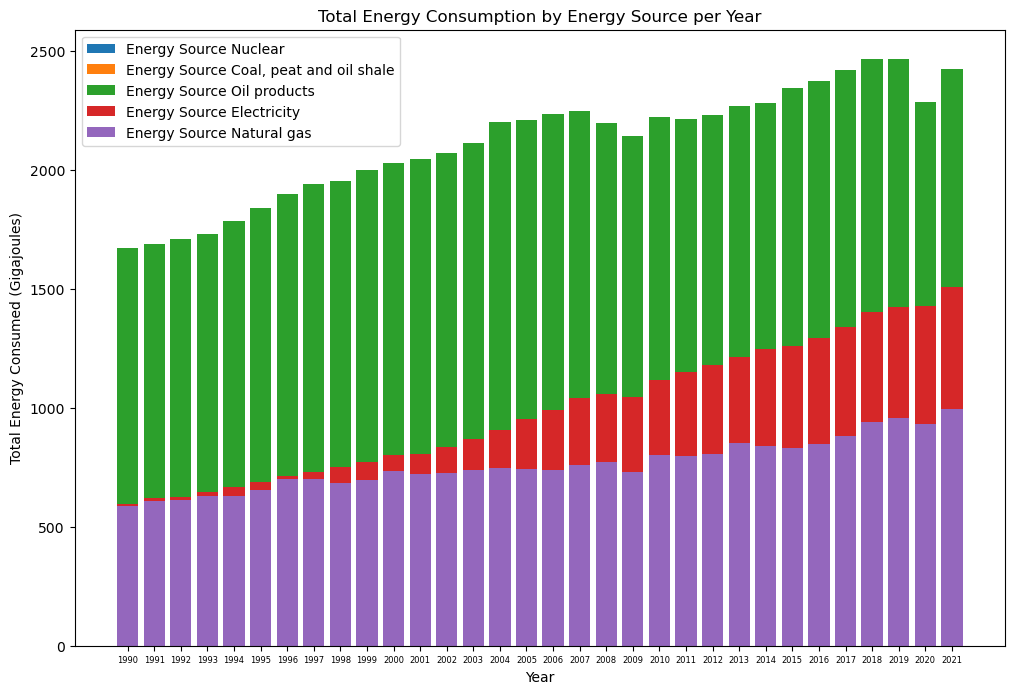

In [103]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Iterate over each energy source to create nested bar plot 
for col in average_energy_per_source_by_year.columns:
    plt.bar(average_energy_per_source_by_year.index, average_energy_per_source_by_year[col], label=col)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Energy Consumed (Gigajoules)')
plt.title('Total Energy Consumption by Energy Source per Year')
plt.xticks(average_energy_per_source_by_year.index, fontsize=6)  
plt.legend()  

# Display the plot
plt.show()

## Does an increase in population impact the distribution of energy sources among specific countries?


In [61]:
# We can answer this question by calculating the percentage of growth in population for each country 
# over the years and then analyzing the distribution of energy sources among those countries.

# Calculate the population for each country and year using a loop
#Array of DataFrames
population_df = []

#Loop to calculate % growth of poulation per country
for country in final_df['Country'].unique():

    country_df = final_df[final_df['Country'] == country].copy()
    country_df['Population Growth'] = country_df['Energy Consumption per Capita'].pct_change() * 100
    country_df['Population Growth'] = country_df['Population Growth'].apply(lambda x: '{:.2f}'.format(x))

    population_df.append(country_df)
#Concat dfs
df_pop_merged = pd.concat(population_df, ignore_index=True)

In [62]:
#  Analyse the growth in energy source per country and year
# # Calculate the growth of each energy source per year and country
energy_sources_df = ['Energy Source Nuclear', 'Energy Source Coal, peat and oil shale', 'Energy Source Oil products', 'Energy Source Electricity', 'Energy Source Natural gas']
for source in energy_sources_df:
    df_pop_merged[f'{source} Growth %'] = df_pop_merged[source].pct_change() * 100
    df_pop_merged[f'{source} Growth %'] = df_pop_merged[f'{source} Growth %'].apply(lambda x: '{:.2f}'.format(x))
# Display the DataFrame with the growth percentage for each energy source
df_pop_merged

,Year,Country,Primary Energy Consumption,Energy Consumption per Capita,CO2 Emissions,Energy Source Nuclear,"Energy Source Coal, peat and oil shale",Energy Source Oil products,Energy Source Electricity,Energy Source Natural gas,Population Growth,Energy Source Nuclear Growth %,"Energy Source Coal, peat and oil shale Growth %",Energy Source Oil products Growth %,Energy Source Electricity Growth %,Energy Source Natural gas Growth %
0,1990,Canada,10.83,391.6,444.8,0,134,2740,1505,1813,nan,nan,nan,nan,nan,nan
1,1991,Canada,10.87,388.2,428.0,0,145,2630,1519,1848,-0.87,nan,8.21,-4.01,0.93,1.93
2,1992,Canada,11.17,393.9,441.9,0,143,2687,1522,1919,1.47,nan,-1.38,2.17,0.20,3.84
3,1993,Canada,11.45,399.3,438.4,0,139,2751,1554,2003,1.37,nan,-2.80,2.38,2.10,4.38
4,1994,Canada,11.88,410.1,453.2,0,135,2857,1575,2073,2.70,nan,-2.88,3.85,1.35,3.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,2017,Thailand,5.17,73.0,287.5,0,314,2257,667,294,1.53,nan,23.14,0.76,0.15,-2.33
1500,2018,Thailand,5.33,75.0,293.2,0,289,2296,677,306,2.74,nan,-7.96,1.73,1.50,4.08
1501,2019,Thailand,5.34,74.9,288.4,0,328,2307,695,296,-0.13,nan,13.49,0.48,2.66,-3.27
1502,2020,Thailand,4.97,69.5,273.1,0,356,2247,674,222,-7.21,nan,8.54,-2.60,-3.02,-25.00


In [24]:
# Find the top 10 countries with the largest total energy consumption for analysis

# Change values to numeric
df_pop_merged['Primary Energy Consumption'] = pd.to_numeric(df_pop_merged['Primary Energy Consumption'], errors='coerce')
df_pop_merged['Population Growth'] = pd.to_numeric(df_pop_merged['Population Growth'], errors='coerce')

# Calculate each country's total energy consumption and population growth for each country across all years
total_energy_and_population = df_pop_merged.groupby('Country').agg({'Primary Energy Consumption': 'sum', 'Population Growth': 'sum'})

# Find the top 10 countries with highest cumulative energy consumption
highest_energy_consumption = total_energy_and_population['Primary Energy Consumption'].nlargest(10)

# Create new DataFrame for top 10 energy spenders for all records (1985-2022)
highest_energy_consumption_df = pd.DataFrame({
    'Country': highest_energy_consumption.index,
    'Total Energy Consumption': highest_energy_consumption.values,
    'Total Population Growth from 1990 - 2021': total_energy_and_population.loc[highest_energy_consumption.index, 'Population Growth'].values
})

# Append '%' sign to the 'Population Growth from 1990 - 2021' column
highest_energy_consumption_df['Total Population Growth from 1990 - 2021'] = highest_energy_consumption_df['Total Population Growth from 1990 - 2021'].map('{:.2f}%'.format)

# Display DataFrame
highest_energy_consumption_df

,Country,Total Energy Consumption,Total Population Growth from 1990 - 2021
0,US,2935.68,-15.79%
1,China,2614.83,155.70%
2,Japan,658.25,-3.83%
3,India,615.99,97.23%
4,Germany,449.60,-20.42%
5,Canada,424.10,-6.85%
6,France,335.70,-13.59%
7,Brazil,309.66,48.83%
8,United Kingdom,285.21,-37.19%
9,Italy,225.86,-7.80%


In [55]:
# Convert to numerical value
df_pop_merged['CO2 Emissions'] = pd.to_numeric(df_pop_merged['CO2 Emissions'], errors='coerce')
df_pop_merged['Population Growth'] = pd.to_numeric(df_pop_merged['Population Growth'], errors='coerce')

# Define columns for comparison
co2_emissions = df_pop_merged['CO2 Emissions']
pop_growth = df_pop_merged['Population Growth']

# Calculate correlation
population_emissions_corr = co2_emissions.corr(pop_growth)
print(f"Correlation between CO2 emissions and population growth: {population_emissions_corr}")

Correlation between CO2 emissions and population growth: 0.0827631872336759


CO2 emissions and population growth have a weak positive correlation. While there is a slight tendency for CO2 emissions and population growth to increase together, the relationship is not very strong. 

Correlation between CO2 emissions and global population growth: 0.04827982855692908


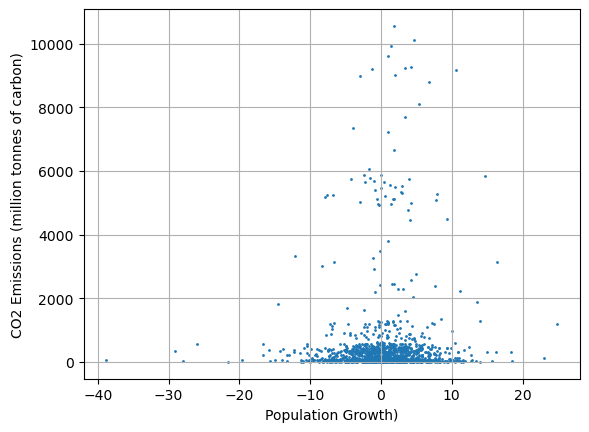

In [97]:
# Create graph to visualize correlation between CO2 emissions and global population growth
population_emissions_corr = co2_emissions.corr(pop_growth)

slope, intercept, rvalue, pvalue, stderr = linregress(pop_growth, co2_emissions)

plt.scatter(pop_growth, co2_emissions, s=1)
plt.plot(pop_growth, slope * pop_growth + intercept, color = 'red')

plt.xlabel('Population Growth)')
plt.ylabel('CO2 Emissions (million tonnes of carbon)')
plt.grid(True)

print(f"Correlation between CO2 emissions and global population growth: {population_emissions_corr}")
plt.show()